# Evaluation of Likelihood using Sequential Monte Carlo

### The particle filter algorithm yields at each step $t$ a weighted sample $(x_t^k, w_t^k)_{k=1}^{N}$ approximating the filtering distribution $p(dx_t|y_{0:t};\theta)$

### The estimators of the marginal liklihood of $\theta$ at time $t$ $$\hat{Z}_t(\theta)=\prod_{s=0}^{t}(\frac{1}{N}\sum_{k=1}^{N}w_s^k)$$

#### p.s:

#### 1.The loaded whisker data is of shape (50,3000), we need to sum it up across axis 0. Then we assume it follows a binomial distribution of N=50.

#### 2.The filtering algorithm in the package returns normalized weights for particle filters, we need to modify it.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import os
import time
import numpy as np
import pandas as pd
import sys
import cPickle as pickle
from   random import *
import scipy.stats
import matplotlib.pyplot as plt
sys.path.insert(1,'./code')
from visualize import plot_raw_data, get_population_data, plot_results
from EM import TransformToProb, RunEM
import pyparticleest.models.nlg as nlg
import pyparticleest.simulator as simulator
import pyparticleest.utils.kalman as kalman
from scipy.stats import bernoulli

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
:0: FutureWarning: IPython widgets are experimental and may change in the future.


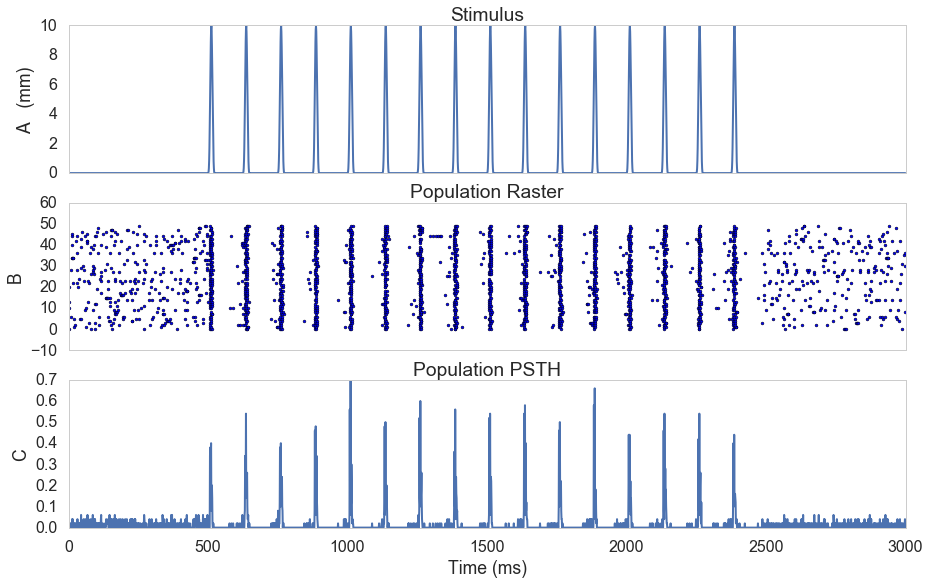

In [3]:
# Get a set of whisker data and plot the raster plot
#path = '/Users/macbookpro/Desktop/Gwungwun/Data/'
path = ""
resp_values_1711 = get_population_data(17,1,1, path = path)
#resp_values_1711 = pickle.load(open('/Users/macbookpro/Documents/ss_model_mixture/resp_values_1711.p','rb'))
plot_raw_data(17,1,1,0,figsize=[15,9],path=path)

resp_values_1711 is the loaded whisker data and it's of shape (50,3000), you need to sum it up across axis 0 and then use the data.

In [9]:
print resp_values_1711.shape
Y = np.sum(resp_values_1711, axis = 0)
print Y.shape

(50, 3000)
(3000,)


In [ ]:
# Run EM on the data set and show results
pmode_1711, p_1711, pll_1711, pul_1711, sigma2e_1711 = RunEM(resp_values_1711)
plot_results(resp_values_1711, pmode_1711, p_1711, pll_1711, pul_1711, ylim=[0,0.75])

In [9]:
print sigma2e_1711

0.505904874894


Create a list of sigmas around `sigma2e_1711`.

In [10]:
sigma_ls = np.arange(sigma2e_1711-0.2, sigma2e_1711+0.2,0.01)
print len(sigma_ls)

41


Now evaluate likelikehood using the list of sigmas. Feel free to play around with the list of sigmas and the step sizes.

We use the nlg.NonlinearGaussianInitialGaussian base class and assume y follows a binomial distribution of $N=50$.

In [116]:
class StdNonLin(nlg.NonlinearGaussianInitialGaussian):
    # x_{k+1} = x_k  + v_k = f(x_k) + v_k,
    # y_k = 0 + e_k = g(x_k) + e_k,
    # x(0) ~ N(0,P0), v_k ~ N(0,Q), e_k ~ Binom(50,\exp(x_{k})/(1+\exp(x_{k})))

    def __init__(self, P0, Q):
    # Set covariances in the constructor since they
    # are constant
        super(StdNonLin, self).__init__(Px0=P0, Q=Q)
        self.lpy = []

#     def calc_g(self, particles, t):
#     # Calculate value of g(\xi_t,t)
#         return np.zeros([len(particles),1])
    
    def calc_f(self, particles, u, t):
    # Calculate value of f(xi_t,t)
        return particles
    
    def measure(self, particles, y, t):
        """
        Return the log-pdf value of the measurement
        Args:
         - particles  (array-like): Model specific representation
           of all particles, with first dimension = N (number of particles)
         - y (array-like):  measurement
         - t (float): time-stamp
        Returns:
         (array-like) with first dimension = N, logp(y|x^i)
        """
        N = len(particles)
#         lpy = np.empty(N)
#         g = self.calc_g(particles=particles, t=t)
 

#         if (g is None):
#             g = np.repeat(self.g.reshape((1, -1, 1)), N, 0)
#         else:
#             g = g.reshape((N, -1, 1))
        yrep = np.repeat(np.asarray(y), N, 0)
    
        lpy = scipy.stats.binom.logpmf(yrep,50,np.exp(particles[:,0])/(1.0 + np.exp(particles[:,0])),loc=0)
    
        return lpy

Let simulator return unnormalized weights

In [117]:
class unnormalizedSimulator(simulator.Simulator):
    def get_filtered_estimates(self):
        """
        Returns type (est, w) (must first have called 'simulate')
         - est: (T, N, D) array containing all particles
         - w: (T,D) array containing all particle weights
        T is the length of the dataset, N is the number of particles and
        D is the dimension of each particle
        """

        T = len(self.pt.traj)
        N = self.pt.traj[0].pa.part.shape[0]
        D = self.pt.traj[0].pa.part.shape[1]

        est = np.empty((T, N, D))

        wtmp = np.empty((T, N))

        for t in xrange(T):
            wtmp[t] = self.pt.traj[t].pa.w
            est[t] = self.pt.traj[t].pa.part

        return (est, wtmp)

In [126]:
#T = 100
#P0 = 0.5 * np.eye(1)
#Q = 0.4 * np.eye(1)

# Forward particles
N = 4000
# Backward trajectories
M = 1

In [127]:
#model = StdNonLin(P0, Q)

#sim = unnormalizedSimulator(model, u=None, y=Y)
#sim.simulate(N, M, filter='PF', smoother='full', meas_first=True)

In [128]:
#(est_filt, w_filt) = sim.get_filtered_estimates()
#w_filt.shape
#np.sum(w_filt, axis = 1)/N

In [129]:
#likelihood=np.sum(np.sum(w_filt, axis = 1)/N)
#print likelihood
#loglikelihood=np.sum(np.log(np.sum(w_filt, axis = 1)/N))
#print loglikelihood

In [130]:
sigma_ls = np.arange(0.01, 0.5, 0.01)

In [133]:
df = pd.read_csv('thaldata.csv',header=None)
Y = df.values.reshape(3000)
#Y = Y[500:800]
T = len(Y)

In [134]:
%%time
%%prun
#likelihood=np.empty(len(sigma_ls))
loglikelihood=np.empty(len(sigma_ls))
logweight=[]
for i in range(len(sigma_ls)):
    print i,
    P0 = sigma_ls[i] * np.eye(1)
    Q = sigma_ls[i]*np.eye(1)
    model = StdNonLin(P0, Q)
    #sim = simulator.Simulator(model,u=None,y=Y)
    sim = unnormalizedSimulator(model, u=None, y=Y)
    sim.simulate(N, M, filter='PF', smoother='ancestor', meas_first=False)
    (est_filt, w_filt) = sim.get_filtered_estimates()
    #logweight = np.reshape(model.lpy,(T,N))
    #weight=np.exp(logweight)
    maxlogweight = np.max(w_filt,axis=1)
    weight = np.exp(w_filt - np.reshape(np.repeat(maxlogweight, N),(T+1, N)))
    loglikelihood[i] = np.sum(np.log(np.sum(weight, axis = 1)/N))+np.sum(maxlogweight)
    #loglikelihood[i]=np.sum(np.log(np.sum(weight, axis = 1)/N))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 CPU times: user 3min 28s, sys: 6.28 s, total: 3min 35s
Wall time: 3min 35s



In [64]:
w_filt

array([[  1.00000000e-02,   1.00000000e-02,   1.00000000e-02, ...,
          1.00000000e-02,   1.00000000e-02,   1.00000000e-02],
       [  1.52631497e-08,   4.60471103e-26,   1.90484497e-19, ...,
          6.28117711e-17,   8.27805018e-10,   2.03981819e-16],
       [  3.50342743e-06,   7.28081083e-06,   3.58840611e-04, ...,
          2.80365867e-07,   9.11026827e-06,   3.43395174e-07],
       ..., 
       [  2.99285005e-04,   8.07649146e-03,   1.79640065e-01, ...,
          7.21547832e-02,   1.22159466e-01,   1.17516043e-01],
       [  2.22491035e-02,   5.72474815e-02,   1.68973677e-01, ...,
          6.86956444e-03,   2.39232341e-02,   8.01610936e-02],
       [  1.84099548e-02,   2.51568425e-02,   4.47560434e-02, ...,
          2.43823329e-02,   6.07121012e-04,   1.69609902e-01]])

In [100]:
logweight = np.reshape(model.lpy,(T,N))
    #weight=np.exp(logweight)
maxlogweight = np.max(logweight,axis=1)
weight = np.exp(logweight - np.reshape(np.repeat(maxlogweight, N),(T, N)))
weight.shape  

ValueError: total size of new array must be unchanged

In [27]:
np.max(np.reshape(model.lpy,(T,N)),axis=1).shape

(300,)

In [135]:
logweight=np.reshape(logweight,(300,100))
print logweight
maxlogweight=np.max(logweight,axis=1)
print maxlogweight

[[ -3.24032094e+01  -9.88465093e+00  -1.81193107e+01 ...,  -2.43716287e+01
   -1.53369671e+01  -3.20749179e+01]
 [ -5.44691755e+00  -6.78017284e+00  -1.52167520e+01 ...,  -5.62731473e+00
   -3.98626724e+00  -1.57091893e+01]
 [ -1.05604350e+01  -5.10960331e+00  -5.46203032e+00 ...,  -7.85254194e+00
   -1.00449573e+01  -1.70337978e+01]
 ..., 
 [ -6.86973751e-01  -3.56667881e-01  -1.98986996e-01 ...,  -1.09396324e+00
   -3.92934364e-01   0.00000000e+00]
 [ -1.15824471e-04  -2.04952369e-03  -7.01572337e-01 ...,  -2.63735475e-02
   -9.45697130e-01  -1.27062353e-01]
 [ -3.68094848e-01  -4.22062479e-01  -3.81520802e-01 ...,  -4.19663809e-04
   -1.58933950e-02  -6.37592936e-05]]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.

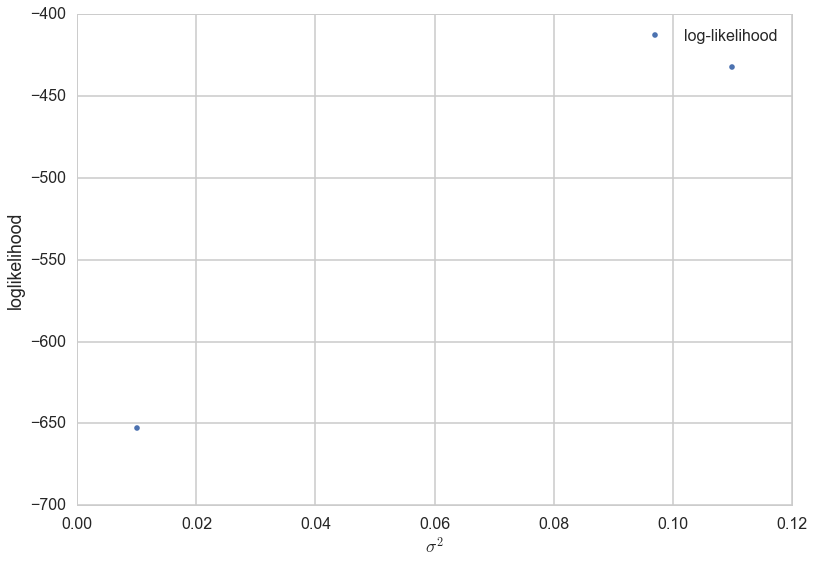

In [74]:
#sigma_ls = np.arange(0.6-0.3, 0.6+0.3+0.01,0.01)
plt.plot(sigma_ls, loglikelihood, '.',linewidth=2.0, label='log-likelihood')
#plt.ylim([-1000,-300])
plt.ylabel('loglikelihood')
plt.xlabel(r'$\sigma^2$')
plt.legend(loc='best')

In [62]:
loglikelihood

array([  79.33088429,  114.34485461])